In [1]:
import numpy as np
import os
import cv2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
def image_batch_generator_with_augmentation(features, labels, batch_size=32, datagen=None):
    while True:
        for start in range(0, len(features), batch_size):
            end = min(start + batch_size, len(features))
            batch_features = features[start:end]
            batch_labels = labels[start:end]

            # Resize images to 224x224 and convert grayscale to RGB
            batch_features_resized = np.array([cv2.resize(frame, (224, 224)) for frame in batch_features])
            batch_features_resized = batch_features_resized.astype('float32')

            # Normalize the images (ResNet50 expects input to be preprocessed)
            batch_features_resized = preprocess_input(batch_features_resized)

            # Apply augmentation using ImageDataGenerator if provided
            if datagen:
                # Use the generator to create augmented images
                augmented_batch = datagen.flow(batch_features_resized, batch_size=batch_size, shuffle=False)
                
                # Instead of using `.next()`, we can use the generator directly in a for loop
                for batch_x in augmented_batch:
                    # Batch_x is the augmented images, but we already have batch_labels, so we use them directly
                    batch_features_resized = batch_x
                    break  # Since we only want the first batch, we break the loop here

            # Yield the batch of data (augmented images and original labels)
            yield batch_features_resized, batch_labels


In [3]:
datagen = ImageDataGenerator(
    rotation_range=30,  # Randomly rotate images
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    shear_range=0.2,  # Apply random shearing transformation
    zoom_range=0.2,  # Randomly zoom images
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill in any missing pixels after transformations
)

In [4]:

from tensorflow.keras.callbacks import EarlyStopping

def classify_with_resnet50(features_train, labels_train, features_val, labels_val, batch_size=32, epochs=10):
    print("Building and training the ResNet50 model...")

    # Load the ResNet50 model with pre-trained weights (Imagenet)
    resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Add a Global Average Pooling layer and a Dense layer for classification
    model = Sequential()
    model.add(resnet_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(np.unique(labels_train)), activation='softmax'))  # Number of classes

    # Compile the model
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Create EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model and capture history
    
    history = model.fit(
        image_batch_generator_with_augmentation(features_train, labels_train, batch_size, datagen),
        steps_per_epoch=len(features_train) // batch_size,
        epochs=epochs,
        validation_data=image_batch_generator_with_augmentation(features_val, labels_val, batch_size,datagen),
        validation_steps=len(features_val) // batch_size,
        callbacks=[early_stopping]
    )

    # Save the model in H5 format
    model.save("resnet_model.h5")
    print("Model saved as resnet_model.h5")

    # Save the model architecture in JSON format
    model_json = model.to_json()
    with open("resnet_model.json", "w") as json_file:
        json_file.write(model_json)
    print("Model architecture saved as resnet_model.json")

    print("Model training completed.")
    return model, history


In [5]:
def process_combined_folders_no_canny(folder_paths, batch_size=1000):
    print(f"Processing {len(folder_paths)} folders with batch size {batch_size}...")

    all_features = []
    all_labels = []

    for folder_path in folder_paths:
        print(f"Processing folder: {folder_path}")
        if 'HorseRace' in folder_path:
            label = 'HorseRace'
        elif 'PlayingViolin' in folder_path:
            label = 'PlayingViolin'
        else:
            raise ValueError(f"Unrecognized folder path: {folder_path}")

        files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))]
        for i in range(0, len(files), batch_size):
            batch_files = files[i:i + batch_size]
            batch_frames = []
            batch_labels = []

            for filename in batch_files:
                frame_path = os.path.join(folder_path, filename)
                frame = cv2.imread(frame_path)
                if frame is None:
                    continue

                # Directly use the raw image as feature (without Canny)
                batch_frames.append(frame)
                batch_labels.append(label)

            batch_features = np.array(batch_frames)
            batch_labels = np.array(batch_labels)

            all_features.append(batch_features)
            all_labels.append(batch_labels)

    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    print(f"Processing completed. {len(all_features)} frames processed.")
    return all_features, all_labels

In [6]:
from sklearn.model_selection import train_test_split

def split_data(features, labels, test_size=0.2, random_state=42):
    """
    Split the data into training and validation sets.
    """
    print("Splitting the data into training and validation sets...")
    
    # Encode labels to integers
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(features, labels_encoded, test_size=test_size, random_state=random_state)
    
    return X_train, X_val, y_train, y_val


In [7]:
def train_model(X_train, y_train, X_val, y_val, batch_size=32, epochs=10):
    """
    Train the ResNet50 model on the training data and return the trained model and history.
    """
    print("Building and training the ResNet50 model...")

    # Resize features for ResNet50 (resize frames to 224x224)
    X_train_resized = np.array([cv2.resize(frame, (224, 224)) for frame in X_train])
    X_val_resized = np.array([cv2.resize(frame, (224, 224)) for frame in X_val])

    # Train the model
    model, history = classify_with_resnet50(X_train_resized, y_train, X_val_resized, y_val, batch_size, epochs)
    
    return model, history


In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(model, X_val, y_val):
    """
    Evaluate the trained model on the validation data and print metrics.
    """
    print("Evaluating the model...")

    # Resize features for ResNet50 (resize frames to 224x224)
    X_val_resized = np.array([cv2.resize(frame, (224, 224)) for frame in X_val])

    # Predict the labels
    y_pred = model.predict(X_val_resized)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_val, y_pred_classes)
    precision = precision_score(y_val, y_pred_classes, average='weighted')
    recall = recall_score(y_val, y_pred_classes, average='weighted')
    f1 = f1_score(y_val, y_pred_classes, average='weighted')

    if len(np.unique(y_val)) == 2:
        roc_auc = roc_auc_score(y_val, y_pred[:, 1])
    else:
        roc_auc = None

    # Print the metrics
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    if roc_auc is not None:
        print(f"ROC-AUC: {roc_auc}")
    else:
        print("ROC-AUC is not applicable for multi-class classification")


In [9]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()

In [10]:
# Path folder dataset
folder_path1 = 'HorseRaceResult/CS_Median_Filtered_Folder'
folder_path2 = 'PlayingViolinResult/CS_Median_Filtered_Folder'

# Process folder with batch processing
features_no_canny, labels_no_canny = process_combined_folders_no_canny([folder_path1, folder_path2], batch_size=500)

Processing 2 folders with batch size 500...
Processing folder: HorseRaceResult/CS_Median_Filtered_Folder
Processing folder: PlayingViolinResult/CS_Median_Filtered_Folder
Processing completed. 51129 frames processed.


In [11]:
# Step 1: Split the data
X_train, X_val, y_train, y_val = split_data(features_no_canny, labels_no_canny)

Splitting the data into training and validation sets...


In [12]:
# Step 2: Train the model
model, history = train_model(X_train, y_train, X_val, y_val)

Building and training the ResNet50 model...
Building and training the ResNet50 model...
Epoch 1/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 3288s 3s/step - accuracy: 0.9716 - loss: 0.0947 - val_accuracy: 0.9939 - val_loss: 0.0171
Epoch 2/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 3158s 2s/step - accuracy: 0.9947 - loss: 0.0147 - val_accuracy: 0.8395 - val_loss: 0.8123
Epoch 3/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 3237s 3s/step - accuracy: 0.9970 - loss: 0.0091 - val_accuracy: 0.9972 - val_loss: 0.0097
Epoch 4/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 3233s 3s/step - accuracy: 0.9968 - loss: 0.0109 - val_accuracy: 0.9845 - val_loss: 0.0717
Epoch 5/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 3245s 3s/step - accuracy: 0.9981 - loss: 0.0069 - val_accuracy: 0.9993 - val_loss: 0.0026
Epoch 6/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 3212s 3s/step - accuracy: 0.9975 - loss: 0.0077 - val_accuracy: 0.9979 - val_loss: 0.0064
Epoch 7/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 3238s 3s/step - accuracy: 0.9977 - loss: 0.0067 - val_accuracy: 0.9950 - val_l

Model saved as resnet_model.h5
Model architecture saved as resnet_model.json
Model training completed.


In [13]:
# Step 3: Evaluate the model
evaluate_model(model, X_val, y_val)

Evaluating the model...
320/320 ━━━━━━━━━━━━━━━━━━━━ 169s 525ms/step
Accuracy: 0.8616272247212986
Precision: 0.8861540288074019
Recall: 0.8616272247212986
F1-Score: 0.8517650033243744
ROC-AUC: 0.9976887708451401


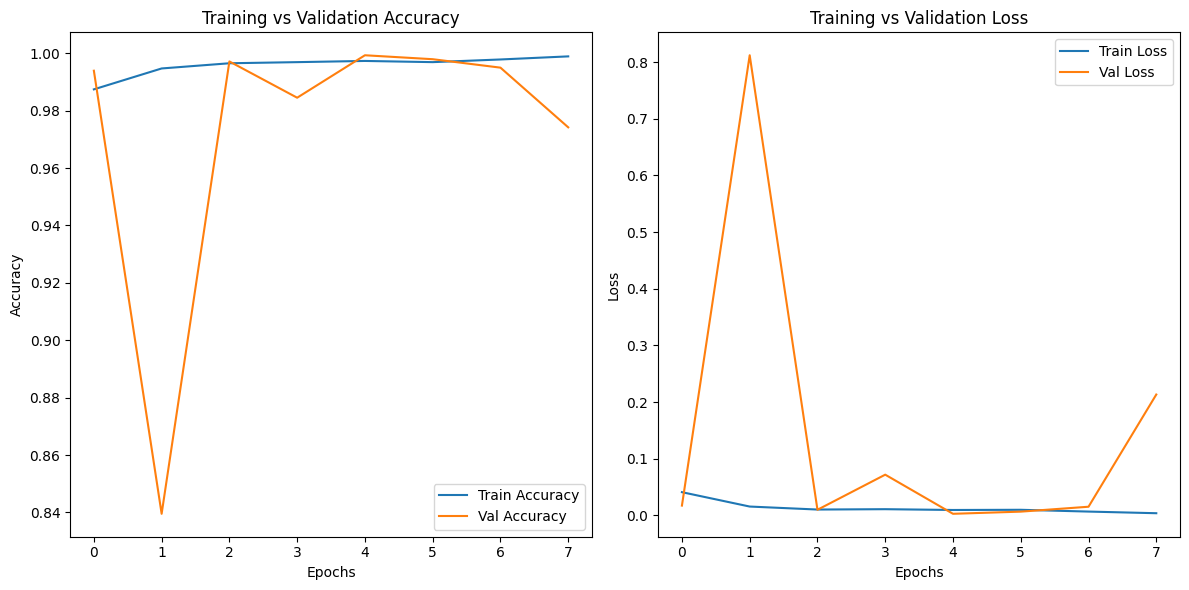

In [ ]:
# Plot the training history
plot_training_history(history)

In [ ]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input

# Function to preprocess a single image (resize and normalize)
def preprocess_single_image(image_path):
    """
    Load and preprocess a single image for prediction.
    Resize to 224x224 and normalize for ResNet50 input.
    """
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error loading image {image_path}")
        return None
    
    # Resize image to 224x224 (input size for ResNet50)
    img_resized = cv2.resize(img, (224, 224))

    # Convert to RGB (if necessary)
    img_resized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

    # Normalize the image for ResNet50 (subtract mean pixel values)
    img_resized = np.expand_dims(img_resized, axis=0)
    img_resized = img_resized.astype('float32')
    img_resized = preprocess_input(img_resized)

    return img_resized

In [21]:
# Function to predict the class of a given image
def predict_image(model, image_path):
    """
    Predict the class of the image using the trained model and display the image with the predicted label.
    """
    # Preprocess the image
    img_resized = preprocess_single_image(image_path)
    
    if img_resized is None:
        return

    # Predict the class using the model
    prediction = model.predict(img_resized)
    predicted_class = np.argmax(prediction, axis=1)

    # Map the predicted class to the corresponding label
    class_names = ['HorseRace', 'PlayingViolin']  # Adjust as needed for your model
    predicted_label = class_names[predicted_class[0]]

    # Display the image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for display
    plt.imshow(img_rgb)
    plt.axis('off')  # Turn off axis
    plt.title(f"Predicted: {predicted_label}")
    plt.show()

    print(f"Predicted class for the image {image_path}: {predicted_label}")
    return predicted_label

In [23]:
# Path to the image for prediction
image_path = 'Violin_CS Filtered.png'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


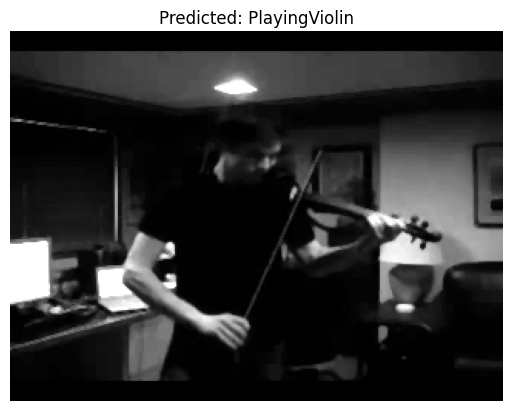

Predicted class for the image Violin_CS Filtered.png: PlayingViolin


'PlayingViolin'

In [24]:
# Make a prediction on the image
predict_image(model, image_path)

In [25]:
# Path to the image for prediction
image_path = 'Horse_CS Filtered.png'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


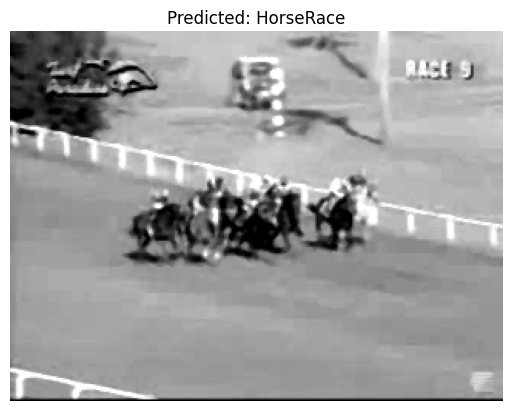

Predicted class for the image Horse_CS Filtered.png: HorseRace


'HorseRace'

In [26]:
# Make a prediction on the image
predict_image(model, image_path)